# Import Thư viện

In [7]:
!pip install tensorflow-text tensorflow-hub tf-keras

In [8]:

import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer #giúp chuyển chữ thành số
from tensorflow.keras.preprocessing.sequence import pad_sequences  #cân bằng về độ dài
from tensorflow.keras import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Embedding, Dense, Dropout, Bidirectional, LSTM, Input, GlobalAveragePooling1D, Flatten
import tensorflow_hub as hub
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()



Lưu dữ liệu qua Drive

In [9]:
from google.colab import drive
import os
drive.mount('/content/drive')
drive_path = '/content/drive/MyDrive/Sentiment_Models'
if not os.path.exists(drive_path): os.makedirs(drive_path)

Mounted at /content/drive


In [10]:
!pip install tensorflow_text
import tensorflow_text as text

# Dataset (Tập dữ liệu)

In [11]:
train_data = pd.read_csv('https://raw.githubusercontent.com/savan77/EmotionDetectionBERT/refs/heads/master/nlp_train.csv')
val_data = pd.read_csv('https://raw.githubusercontent.com/savan77/EmotionDetectionBERT/refs/heads/master/nlp_valid.csv')
test_data = pd.read_csv('https://raw.githubusercontent.com/savan77/EmotionDetectionBERT/refs/heads/master/nlp_test.csv')

In [12]:
train_data.head()

,id,text,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust,neutral
0,0,He was answering a question about the criticis...,1,0,1,0,0,0,0,1,0,0,0,0
1,1,I'm going to start today's discussion thread w...,1,1,1,1,0,0,0,1,0,0,0,0
2,2,"By announcing the 395 self-quarantined, it pai...",1,1,1,1,0,0,0,1,0,0,0,0
3,3,"Likewise, sorry if I offended you. I’m not act...",1,0,1,1,0,0,0,1,0,0,0,0
4,4,"People infected by experience high fever, coug...",0,0,0,0,0,0,0,0,0,0,0,1


In [13]:
val_data.head()

,id,text,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust,neutral
0,0.0,He was answering a question about the criticis...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1.0,I'm going to start today's discussion thread w...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,2.0,"By announcing the 395 self-quarantined, it pai...",1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,3.0,"Likewise, sorry if I offended you. I’m not act...",1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,4.0,"People infected by experience high fever, coug...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [14]:
test_data.head()

,id,text,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust,neutral
0,0,&gt; # First passengers exit quarantined Japan...,0,1,0,1,0,0,1,0,1,0,0,0
1,1,"This is the best tl;dr I could make, [original...",0,0,0,0,0,0,0,0,0,0,0,1
2,2,Absolutely. Trade is good for everyone.\n\nBut...,0,0,1,0,0,0,0,0,0,0,0,0
3,3,He says the elderly should stay home. I have t...,0,0,0,1,0,0,0,1,0,0,0,0
4,4,&gt; A couple of million wont die in the US.\n...,0,1,0,1,0,0,0,1,1,1,0,0


In [15]:
train_sentiment_data = train_data.dropna().reset_index(drop=True)

val_sentiment_data = val_data.dropna().reset_index(drop=True)

test_sentiment_data = test_data.dropna().reset_index(drop=True)

label_class = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust', 'neutral']

input_data_train = train_sentiment_data['text'].values
label_data_train = train_sentiment_data[label_class].values

input_data_val = val_sentiment_data['text'].values
label_data_val = val_sentiment_data[label_class].values

input_data_test = test_sentiment_data['text'].values
label_data_test = test_sentiment_data[label_class].values

print("Input train shape: ", input_data_train.shape)
print("Label train shape: ", label_data_train.shape)
print("Input train shape: ", input_data_val.shape)
print("Label train shape: ", label_data_val.shape)
print("Input train shape: ", input_data_test.shape)
print("Label train shape: ", label_data_test.shape)

Input train shape:  (1493,)
Label train shape:  (1493, 12)
Input train shape:  (165,)
Label train shape:  (165, 12)
Input train shape:  (374,)
Label train shape:  (374, 12)


# Training with Pretrain Word Emebedding


In [16]:
embedding = 'https://tfhub.dev/google/nnlm-en-dim50/2'
hub_layer = hub.KerasLayer(embedding, input_shape=[], dtype=tf.string, trainable=True)
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(12, activation='sigmoid'))
model.summary()

adam = Adam(learning_rate=0.001)
model.compile(
    optimizer=adam,
    loss='binary_crossentropy', metrics=[tf.keras.metrics.BinaryAccuracy(
        name="binary_accuracy", dtype=None, threshold=0.5
    )]
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 50)                48190600  
                                                                 
 dense (Dense)               (None, 32)                1632      
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 12)                204       
                                                                 
Total params: 48192964 (183.84 MB)
Trainable params: 48192964 (183.84 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
path_ge = os.path.join(drive_path, 'model_google_embedding.h5')
if os.path.exists(path_ge):
    model.load_weights(path_ge)
else:
    cb = tf.keras.callbacks.ModelCheckpoint(path_ge, monitor="val_loss", save_best_only=True, save_weights_only=True)
    history = model.fit(x=input_data_train, y=label_data_train, epochs=50,
                        validation_data=(input_data_val, label_data_val), callbacks=[cb])

In [18]:
model.load_weights('/content/drive/MyDrive/Sentiment_Models/model_google_embedding.h5')
model.evaluate(input_data_test, label_data_test)
preds = model.predict(input_data_test)
preds = tf.round(preds).numpy()
print(classification_report(label_data_test, preds, target_names=label_class, zero_division = 0))

12/12 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

       anger       0.55      0.68      0.61       121
anticipation       0.72      0.67      0.69       218
     disgust       0.66      0.77      0.71       156
        fear       0.66      0.67      0.66       195
         joy       0.36      0.06      0.10        70
        love       0.18      0.07      0.10        30
    optimism       0.32      0.40      0.36        97
   pessimism       0.45      0.72      0.56       120
     sadness       0.44      0.27      0.34       136
    surprise       0.31      0.08      0.13        49
       trust       0.47      0.15      0.23        60
     neutral       0.62      0.13      0.22        38

   micro avg       0.56      0.52      0.54      1290
   macro avg       0.48      0.39      0.39      1290
weighted avg       0.54      0.52      0.50      1290
 samples avg       0.51      0.48      0.46      1290



# Training with Bert

In [19]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3', name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/2', trainable=False, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dense(400, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(200, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(100, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(50, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(12, activation='sigmoid', name='classifier')(net)
    return tf.keras.Model(inputs = text_input, outputs = net)

classifier_model = build_classifier_model()
classifier_model.summary()
adam = Adam(learning_rate=0.001)
metric_acc = tf.keras.metrics.BinaryAccuracy(name="binary_accuracy", dtype=None, threshold=0.5)
classifier_model.compile(optimizer=adam, loss='binary_crossentropy', metrics=metric_acc)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 preprocessing (KerasLayer)  {'input_type_ids': (None,    0         ['text[0][0]']                
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             , 'input_word_ids': (None,                                           
                              128)}                                                               
                                                                                              

In [20]:
path_bert = os.path.join(drive_path, 'model_small_bert.h5')

if os.path.exists(path_bert):
    classifier_model.load_weights(path_bert)
else:
    cb = tf.keras.callbacks.ModelCheckpoint(path_bert, monitor="val_loss", save_best_only=True, save_weights_only=True)
    history = classifier_model.fit(x=input_data_train, y=label_data_train, epochs=50,
                                   validation_data=(input_data_val, label_data_val), callbacks=[cb])

In [21]:
classifier_model.load_weights('/content/drive/MyDrive/Sentiment_Models/model_small_bert.h5')
classifier_model.evaluate(input_data_test, label_data_test)

preds = classifier_model.predict(input_data_test)
preds = tf.round(preds).numpy()
print(classification_report(label_data_test, preds, target_names=label_class, zero_division = 0))

12/12 [==============================] - 2s 137ms/step
              precision    recall  f1-score   support

       anger       0.61      0.52      0.56       121
anticipation       0.67      0.64      0.66       218
     disgust       0.65      0.56      0.60       156
        fear       0.63      0.58      0.61       195
         joy       0.38      0.09      0.14        70
        love       0.31      0.17      0.22        30
    optimism       0.37      0.41      0.39        97
   pessimism       0.48      0.62      0.54       120
     sadness       0.52      0.24      0.33       136
    surprise       0.00      0.00      0.00        49
       trust       0.37      0.12      0.18        60
     neutral       0.29      0.29      0.29        38

   micro avg       0.55      0.45      0.50      1290
   macro avg       0.44      0.35      0.38      1290
weighted avg       0.52      0.45      0.47      1290
 samples avg       0.48      0.43      0.42      1290



In [22]:
test_input = 'He was answering a question about the criticism by the same individual s that were referring to it as The Chinese and Wuhan Corona Virus last'

def predict_sentiment(input, model):
  pred_result = classifier_model.predict([test_input])
  pred_result = list(tf.round(pred_result).numpy()[0])
  for v,l in zip(pred_result, label_class):
    if v == 1.0:
      print(l)

predict_sentiment(test_input,classifier_model)

1/1 [==============================] - 0s 71ms/step
disgust
joy
trust


# Training with traditional LSTM + RNN

<Axes: >

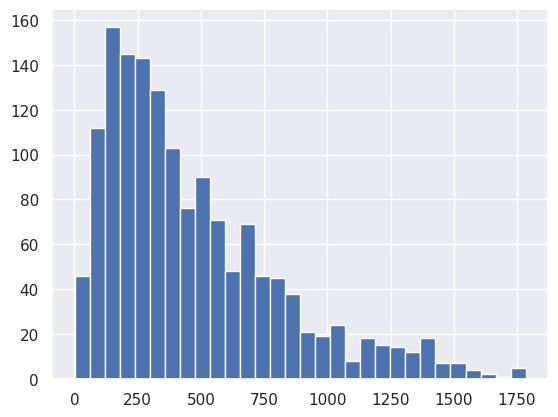

In [23]:
#get length of all the messages in the train set
seq_len = [len(i.split()) for i in input_data_train]
pd.Series(seq_len).hist(bins = 30)

In [24]:
tokenizer_data = Tokenizer(oov_token='<OOV>', filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', split=' ')
tokenizer_data.fit_on_texts(input_data_train)

tokenized_data_train = tokenizer_data.texts_to_sequences(input_data_train)
vec_data_train = pad_sequences(tokenized_data_train, padding='post', maxlen=250)

tokenized_data_val = tokenizer_data.texts_to_sequences(input_data_val)
vec_data_val = pad_sequences(tokenized_data_val, padding='post', maxlen=250)

data_vocab_size = len(tokenizer_data.word_index) + 1
print("Input vector training: ", vec_data_train.shape)
print("Input vector val: ", vec_data_val.shape)
print("Vocab size: ", data_vocab_size)

Input vector training:  (1493, 250)
Input vector val:  (165, 250)
Vocab size:  34232


In [25]:
# Training with traditional LSTM + RNN
dropout_threshold = 0.4
model = Sequential()
input_dim = data_vocab_size
output_dim = 60
input_length = 250

# Add Embedding layer
model.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length))
# Add bidirectional LSTM
model.add(Bidirectional(LSTM(units=output_dim, dropout = dropout_threshold, return_sequences=True), merge_mode = 'concat'))

model.add(Bidirectional(LSTM(units=output_dim, return_sequences=True)))
model.add(GlobalAveragePooling1D())
model.add(Dense(500, activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(200, activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(100, activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(50, activation = 'relu'))
model.add(Dense(12, activation = 'sigmoid'))

adam = Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=tf.keras.metrics.BinaryAccuracy(
    name="binary_accuracy", dtype=None, threshold=0.5
))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 60)           2053920   
                                                                 
 bidirectional (Bidirection  (None, 250, 120)          58080     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 250, 120)          86880     
 onal)                                                           
                                                                 
 global_average_pooling1d (  (None, 120)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense_7 (Dense)             (None, 500)               60500     
                                                      

In [26]:
path_lstm = os.path.join(drive_path, 'model_lstm.h5')

if os.path.exists(path_lstm):
    model.load_weights(path_lstm)
else:
    cb = tf.keras.callbacks.ModelCheckpoint(path_lstm, monitor="val_loss", save_best_only=True, save_weights_only=True)
    history = model.fit(x=vec_data_train, y=label_data_train, epochs=50,
                        validation_data=(vec_data_val, label_data_val), callbacks=[cb])

In [27]:
tokenized_data_test = tokenizer_data.texts_to_sequences(input_data_test)
vec_data_test = pad_sequences(tokenized_data_test, padding='post', maxlen = 250)

model.load_weights('/content/drive/MyDrive/Sentiment_Models/model_lstm.h5')
model.evaluate(vec_data_test, label_data_test)

preds = model.predict(vec_data_test)
preds = tf.round(preds).numpy()

print(classification_report(label_data_test, preds, target_names=label_class, zero_division = 0))

12/12 [==============================] - 2s 15ms/step
              precision    recall  f1-score   support

       anger       0.61      0.61      0.61       121
anticipation       0.63      0.71      0.67       218
     disgust       0.60      0.73      0.66       156
        fear       0.58      0.76      0.65       195
         joy       0.50      0.10      0.17        70
        love       0.25      0.03      0.06        30
    optimism       0.31      0.49      0.38        97
   pessimism       0.43      0.69      0.53       120
     sadness       0.39      0.40      0.40       136
    surprise       0.08      0.08      0.08        49
       trust       0.41      0.22      0.28        60
     neutral       0.20      0.03      0.05        38

   micro avg       0.50      0.54      0.52      1290
   macro avg       0.41      0.41      0.38      1290
weighted avg       0.49      0.54      0.50      1290
 samples avg       0.46      0.49      0.44      1290



# Giao diện

In [28]:
import gradio as gr
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import base64

print("Đang tải các mô hình vào bộ nhớ...")

# --- Load Small BERT ---
try:
    model_bert = build_classifier_model()
    model_bert.load_weights(os.path.join(drive_path, 'model_small_bert.h5'))
    print("Đã load xong Small BERT")
except:
    print("Chưa load được Small BERT (Kiểm tra lại file .h5)")
    model_bert = None

# --- Load Google Embedding ---
try:
    model_ge = tf.keras.Sequential([
        hub.KerasLayer('https://tfhub.dev/google/nnlm-en-dim50/2', input_shape=[], dtype=tf.string, trainable=True),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(12, activation='sigmoid')
    ])
    model_ge.load_weights(os.path.join(drive_path, 'model_google_embedding.h5'))
    print("Đã load xong Google Embedding")
except:
    print("Chưa load được Google Embedding")
    model_ge = None

# --- Load LSTM ---
model.load_weights(os.path.join(drive_path, 'model_lstm.h5'))
model_lstm = model
print("Đã load xong LSTM (từ bộ nhớ hiện tại)")


def predict_sentiment(text_input, model_choice):
    if not text_input:
        return "Vui lòng nhập văn bản!"

    # Chọn mô hình dựa trên menu
    selected_model = None
    is_lstm = False

    if model_choice == "Small BERT":
        selected_model = model_bert
    elif model_choice == "Google Embedding":
        selected_model = model_ge
    elif model_choice == "LSTM/RNN":
        selected_model = model_lstm
        is_lstm = True

    if selected_model is None:
        return "Mô hình chưa được tải thành công!"

    # Xử lý dữ liệu đầu vào
    try:
        if is_lstm:
            seq = tokenizer_data.texts_to_sequences([text_input])
            processed_input = pad_sequences(seq, padding='post', maxlen=250)
        else:
            processed_input = [text_input]

        prediction = selected_model.predict(processed_input)

        pred_array = prediction[0]
        results = []

        for i, prob in enumerate(pred_array):
            if prob > 0.5:
                results.append(f"{label_class[i]} ({prob:.2%})")

        if not results:
            return "Neutral / Không rõ cảm xúc (Tất cả < 50%)"

        return ", ".join(results)

    except Exception as e:
        return f"Lỗi khi dự đoán: {str(e)}"

Đang tải các mô hình vào bộ nhớ...
Đã load xong Small BERT
Đã load xong Google Embedding
Đã load xong LSTM (từ bộ nhớ hiện tại)


In [29]:
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        encoded_string = base64.b64encode(image_file.read()).decode('utf-8')
    return f"data:image/jpeg;base64,{encoded_string}"
image_path = "/content/drive/MyDrive/AI/background.jpg"
try:
    base64_img = encode_image(image_path)
except FileNotFoundError:
    print(f"Không tìm thấy file: {image_path}. Hãy kiểm tra lại tên file hoặc đường dẫn.")
    base64_img = ""

css_code = f"""
.gradio-container {{
    background-image: url("{base64_img}");
    background-size: cover;
    background-position: center;
    background-attachment: fixed;
    background-repeat: no-repeat;
}}

.gradio-container .input-container,
.gradio-container .output-container,
.gradio-container .form {{
    background-color: rgba(255, 255, 255, 0.85) !important;
    border-radius: 10px;
}}
.gradio-container h1 {{
    color: black !important;
}}
"""

emotion_theme = gr.themes.Soft(
    primary_hue="pink",
    font=[gr.themes.GoogleFont("Quicksand"), "sans-serif"]
)

interface = gr.Interface(
    fn=predict_sentiment,
    inputs=[
        gr.Textbox(lines=3, placeholder="Nhập văn bản... ✨", label="💬 Văn bản"),
        gr.Dropdown(["Small BERT", "Google Embedding", "LSTM/RNN"], label="🤖 Mô hình", value="Google Embedding")
    ],
    outputs=gr.Textbox(label="🌈 Kết quả"),
    title="🎭 PHÂN TÍCH CẢM XÚC",
    theme=emotion_theme,
    css=css_code
)


interface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://2d3b5f1faf3bc5bdc2.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
